# Convulutional Neural Networks & LSTM for Image Captioning (Flickr 8k)


## Import Libraries

In [ ]:
#Basic Libraries
import numpy as np
from matplotlib import pyplot as plt

#Portable Operating System
import os

#Set OS environment for Keras as tensorflow; this is the architecture for our deep learning models
os.environ['KERAS_BACKEND'] = "tensorflow"

#Regular Expression
import re

#For File Name Manipulation
from glob import glob

#Patch for Google Colab using cv2_imshow()
from google.colab.patches import cv2, cv2_imshow

#TensorFlow for data structures/pipelines
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

#Keras - Used for Building Nueral Networks with Libraries
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

## Importing Dataset

In [ ]:
##Data set provided via github by:
#M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics",
#Journal of Artifical Intellegence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

In [ ]:
#Get datasets from github
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#Unzip Zip files
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
#Delete Uneccesary Files
!rm Flickr8k_Dataset.zip Flickr8k_text.zip
!rm Flickr_8k.testImages.txt Flickr_8k.devImages.txt Flickr8k.lemma.token.txt
!rm CrowdFlowerAnnotations.txt Flickr_8k.trainImages.txt ExpertAnnotations.txt

In [ ]:
#Navigate to Files Brought In by GitHub

# Current working directory
current_dir = os.getcwd()

# List files in the current directory
files_in_dir = os.listdir(current_dir)

# Iterate over files and print their full paths
for file_name in files_in_dir:
    file_path = os.path.join(current_dir, file_name)
    print(file_path)

/content/.config
/content/Flicker8k_Dataset
/content/readme.txt
/content/__MACOSX
/content/Flickr8k.token.txt
/content/sample_data


##Global Variables

In [ ]:
#File Path Name for Images
img_file = "Flicker8k_Dataset"

#Fixed token length used to limit caption # of tokens
#Originally 28
#Caption length median is 13
#Lowering the value to 13 from 28 may increase accuracy since string is shorter to guess
Sequence_size = 13

#Image dimension for printing with plt
#Originally (300,300)
#350 appears to return a better accuracy
img_dim = (350, 350)

#Vocabulary Size
Vocabulary_count = 10000

#Embed Dim 512 had a ~50% accuracy with approx 12-18 epochs to train
#Embed Dim 420 had a ~47% accuracy with 17 epochs to train
#Embed Dim 50 returns ~38% accuracy with more than 30 epoches required to converge
EMBED_DIM = 512

#Per-layer units in the feedforward network
FF_DIM = 512
#Other Training Params
Batch_size = 64
#Epochs can take about 2 minutes each, models exceeding 20 also did not appear to provide
#better accuracy
EPOCHS = 10
Autotune = tf.data.AUTOTUNE

##Prepare the Dataset

We have two primary data sources: Flicker8k_Dataset and Flickr8k.token.txt

Flick8k_Dataset stores .JPEG files, which can be read as matrixes of pixels, with 3 channels (Red, Green, Blue; color photos).

Flickr8k.token.txt stores 5 captions for each photo as follows:
*   '#1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .'
*   '#1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .'

In [ ]:
#Get the number of images
image_count = 0
for path in os.listdir(img_file):
    if os.path.isfile(os.path.join(img_file, path)):
        image_count += 1
print(f'Images in Data Set: {image_count}')

Images in Data Set: 8091


In [ ]:
#Create a dictionary where Key = image name, Value = Captions; caption_mapping
#And list of all captions; text_data
def get_captions(filename):

    #Read each line of the file
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        #Create Placeholder variables
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

    #Process Caption text
        #Remove line breaks, and split image name from caption using tab delimited
        for line in caption_data:
            line = line.rstrip('\n')
            img_name, caption = line.split('\t')

            #Standardize all image names as Flicker_8kDataset + alpha text of original image name
            img_name = img_name.split('#')[0]
            img_name = os.path.join(img_file, img_name.strip())

            #We will remove captions that are either too short to too long
            #if token is < # or > Sequence_size, add image name to skip list
            #Looking at the seq length distribution range [6,30] appears non-outlier
            tokens = caption.strip().split()
            if len(tokens) < 6 or len(tokens) > 30:
                images_to_skip.add(img_name)
                continue
            #If image is not in skip list, add <start> and <end> tokens, and append to text_data
            if img_name.endswith("jpg") and img_name not in images_to_skip:
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)
                #If image name exists in the caption mapping dict, add the caption
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                #Else create new Key with caption
                else:
                    caption_mapping[img_name] = [caption]
        #Images with tokens too big or small, are deleted from the caption map
        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

In [ ]:
# Load the dataset
caption_mapping, text_data = get_captions("Flickr8k.token.txt")

In [ ]:
#Stores Dictionary of Image Name Keys and Caption Values
caption_mapping['Flicker8k_Dataset/1000268201_693b08cb0e.jpg']

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
#Stores a list of all captions
text_data[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

In [ ]:
#Create a list of all image file paths
all_images = list(caption_mapping.keys())
print(all_images[:3])

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg']


In [ ]:
#Check how many images the function removed
print("Total images removed by function due to sequence length criteria: ", (image_count - len(all_images)))
print("% of original database remaining: ",round((len(all_images)/image_count),3))

Total images removed by function due to sequence length criteria:  807
% of original database remaining:  0.9


In [ ]:
#Create a Function to take a sample of images and captions from selected images
def sample_Images(number):
    for number in range(10):
        x = np.random.choice(all_images)
        z = all_images.index(x)
        image = cv2.imread(all_images[z])
        caption = caption_mapping[x]
        print(caption)
        cv2_imshow(image)
        print('\n')

['<start> A group of people in green shirts push a cannon in a parade . <end>', '<start> People in matching outfits next to a canon . <end>', '<start> Several people dressed in like jerseys roll an old cannon during a competition . <end>', '<start> Six men are pushing a large wooden wheel along the ground in front of an audience . <end>', '<start> Young adults wearing uniforms wheel a contraption . <end>']


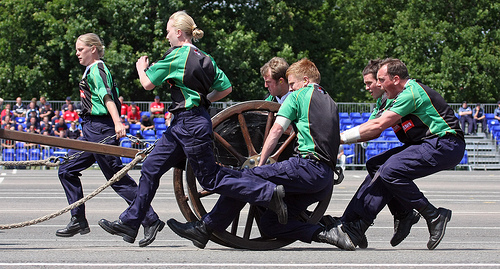



['<start> A man in a red kayak . <end>', '<start> a man in a red kayak pedalling through a wave <end>', '<start> A man is kayaking in the ocean on an orange kayak . <end>', '<start> A person in a kayak rides waves in the ocean . <end>', '<start> The male kayaker is moving through the rough water . <end>']


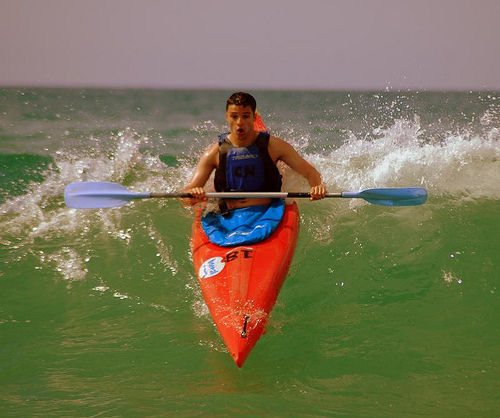



['<start> A dog is running while another dog behind it carries a tennis ball . <end>', '<start> A dog runs with another dog in the background holding a ball in its mouth . <end>', '<start> Two black and white dogs running in a field . <end>', '<start> Two black and white dogs walking on dirt , one of which has a ball in its mouth . <end>', '<start> Two dogs are running in the dirt , one with a ball in its mouth . <end>']


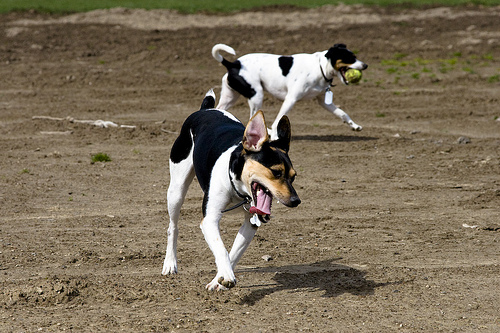



['<start> A group of boys is watching another boy walk away . <end>', '<start> A group of boys with croquet equipment stands on a lawn . <end>', '<start> A kid runs in the opposite direction of others who were playing a game . <end>', '<start> Boys are standing outside of a brick establishment whie one boy starts to run . <end>', '<start> Six pre-teen boys posing in front of an old building <end>']


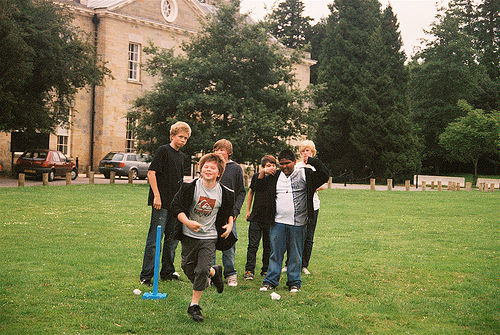



['<start> A cyclist rides down a rocky mountain . <end>', '<start> A man in aerodynamic gear riding a professional mountain bike through a forest . <end>', '<start> A man on a mountain bike outdoors . <end>', '<start> a man wearing a blue helmet riding a bike in the woods . <end>', '<start> A mountain biker rides through a bike path . <end>']


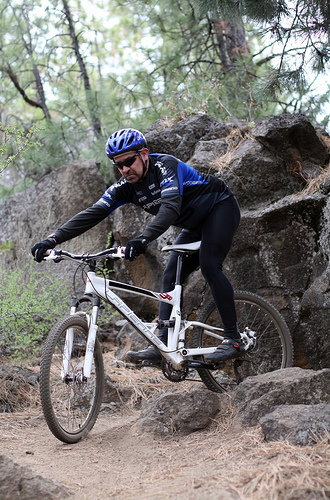



['<start> a man in red shorts is walking along rocks by a river carrying a stick . <end>', '<start> A man in red shorts standing on rocks by a stream <end>', '<start> A man is walking on rocks with water flowing around them . <end>', '<start> A shirtless man standing on the edge of a stream . <end>', '<start> The hiker nears a creek . <end>']


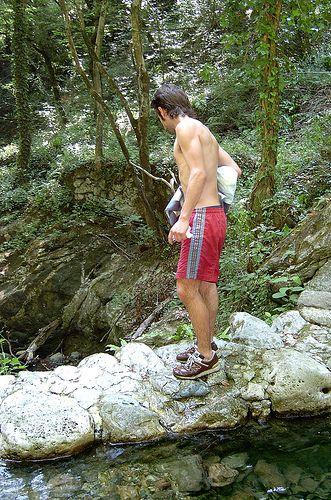



['<start> a small dog steps onto a log . <end>', '<start> A small white dog climbs over a log . <end>', '<start> A small white dog with a blue collar is climbing over a large log . <end>', '<start> A white dog jumps over a log outside . <end>', '<start> A white terrior is jumping over a log . <end>']


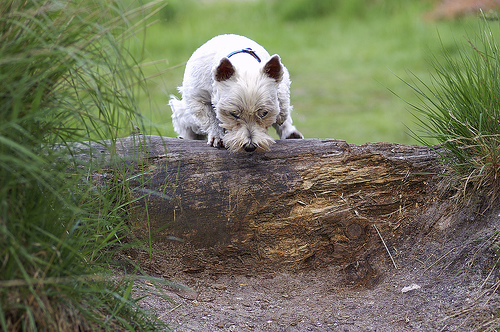



['<start> Man and woman walking near the ocean . <end>', '<start> Two people are walking alongside a decorative railing while wearing winter gear . <end>', '<start> Two people are walking by the ocean . <end>', '<start> Two people in coats walking next to a fence . <end>', '<start> Two people walk together on a cold day . <end>']


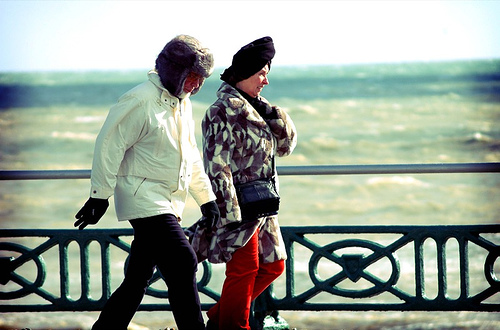



['<start> A blond man with big blue eyes is smiling <end>', '<start> A man in a green scarf is bearing his teeth . <end>', '<start> A man making a funny face towards the camera using wide eyes and a large smile . <end>', '<start> A man with red hair grins . <end>', '<start> A strawberry haired guy flashes his blue eyes and big smile at the camera . <end>']


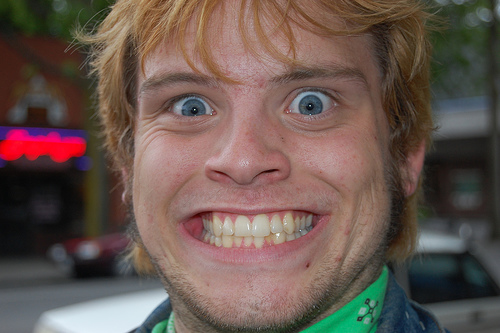



['<start> A man in a Miami basketball uniform looking to the right <end>', '<start> a man wears a orange jersey . <end>', '<start> A Miami basketball player looks off in the distance . <end>', '<start> The mans shirt is orange and has a United States flag patch on the shoulder . <end>', '<start> The Miami basketball player is looking . <end>']


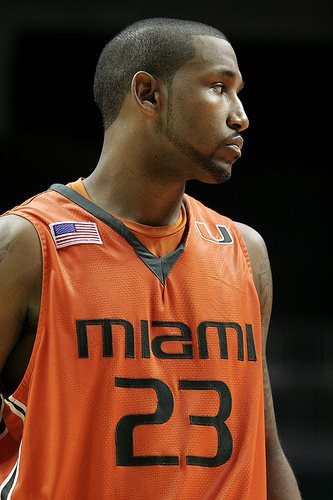

In [ ]:
sample_Images(5)

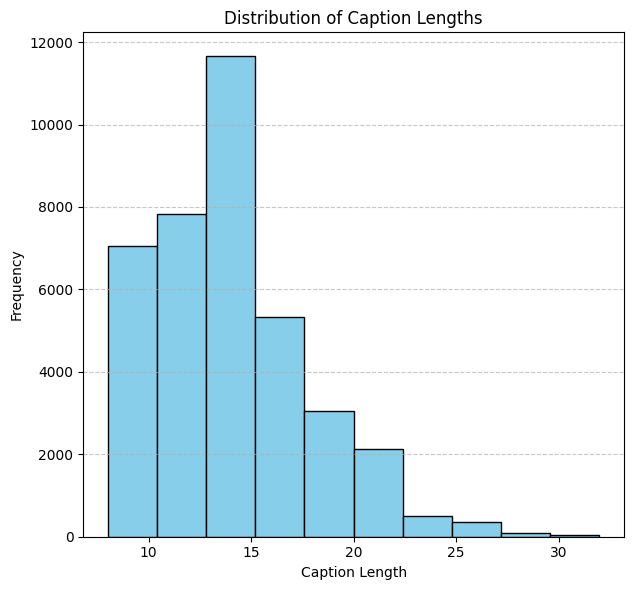

In [ ]:
import matplotlib.pyplot as plt

# Calculate caption lengths
caption_lengths = [len(caption.split()) for caption in text_data]

# Calculate number of captions per image
captions_per_image = [len(captions) for captions in caption_mapping.values()]

# Plot histogram
plt.figure(figsize=(12, 6))

# Subplot for caption length
plt.subplot(1, 2, 1)
plt.hist(caption_lengths, color='skyblue', edgecolor='black')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import statistics
statistics.median(caption_lengths)

13.0

**Splitting train and test data**

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)
    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the split
    return training_data, validation_data

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(caption_mapping)
print("Number of training samples: ", len(train_data))
print("% of original database used for training: ", round((len(train_data)/image_count),3))
print("Number of validation samples: ", len(valid_data))
print("% of original database used for validation: ", round((len(valid_data)/image_count),3))

Number of training samples:  5827
% of original database used for training:  0.72
Number of validation samples:  1457
% of original database used for validation:  0.18


In [ ]:
#Text Standardization - Stripping punctuation (strip_chars) and splitting on white space

strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

<>:3: SyntaxWarning: invalid escape sequence '\]'
<>:3: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-904669842.py:3: SyntaxWarning: invalid escape sequence '\]'
  strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"


In [ ]:
#Convert text to vocabulary vector using Keras layer
#Words are replaced by their index number from the overall vocab set
vectorization = TextVectorization(
    max_tokens=Vocabulary_count,
    output_mode="int",
    output_sequence_length=Sequence_size,
    standardize=custom_standardization,
)

vectorization.adapt(text_data)

In [ ]:
text_data[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

##Building a Pipeline for Training

Goals: Read the image, tokenize all 5 corresponding captions

In [ ]:
#Data Augmentation for Image Data Will alter the image to make training more robust
#Use keras.Sequential to group linear stack of layers into a tf.keras.Model
image_augmentation = keras.Sequential(
    [
        #Randomly flip images horizontally during training
        #Original Value horizontal
        layers.RandomFlip("horizontal"),
        #Randomly rotates images during training
        #Original Value 0.1
        layers.RandomRotation(0.1),
        #Randomly adjusts contrast in images during training
        #Original Value 0.3
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
#Read input file, resize, and convert to float 32
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_dim)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [ ]:
decode_and_resize('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

<tf.Tensor: shape=(350, 350, 3), dtype=float32, numpy=
array([[[ 52.69388  ,  55.507652 ,  75.25765  ],
        [109.57143  , 128.57143  , 125.76021  ],
        [108.53826  , 127.359695 , 122.86479  ],
        ...,
        [  3.3801181,   4.9846716,   1.377581 ],
        [  4.7448907,   7.3188677,   2.6020336],
        [  5.1351995,   7.4336767,   2.0280783]],

       [[ 49.295918 ,  52.890305 ,  69.71429  ],
        [109.13521  , 128.70918  , 121.625    ],
        [109.96428  , 128.67091  , 124.80102  ],
        ...,
        [  6.2192903,   7.385088 ,   4.234619 ],
        [  8.61734  ,  11.505089 ,   8.124985 ],
        [  1.0027272,   5.3828   ,   2.2322845]],

       [[ 46.2602   ,  47.92857  ,  66.91327  ],
        [109.19898  , 128.82907  , 121.1046   ],
        [111.533165 , 130.11734  , 130.37755  ],
        ...,
        [  5.7449074,   7.1683702,   8.459192 ],
        [  5.6428585,  10.969373 ,   3.446452 ],
        [ 19.831312 ,  29.887342 ,   9.331485 ]],

       ...,

     

In [ ]:
#Get decoded and resized image, with vectorized captions
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

In [ ]:
process_input('Flicker8k_Dataset/1000268201_693b08cb0e.jpg', caption_mapping['Flicker8k_Dataset/1000268201_693b08cb0e.jpg'])

(<tf.Tensor: shape=(350, 350, 3), dtype=float32, numpy=
 array([[[ 52.69388  ,  55.507652 ,  75.25765  ],
         [109.57143  , 128.57143  , 125.76021  ],
         [108.53826  , 127.359695 , 122.86479  ],
         ...,
         [  3.3801181,   4.9846716,   1.377581 ],
         [  4.7448907,   7.3188677,   2.6020336],
         [  5.1351995,   7.4336767,   2.0280783]],
 
        [[ 49.295918 ,  52.890305 ,  69.71429  ],
         [109.13521  , 128.70918  , 121.625    ],
         [109.96428  , 128.67091  , 124.80102  ],
         ...,
         [  6.2192903,   7.385088 ,   4.234619 ],
         [  8.61734  ,  11.505089 ,   8.124985 ],
         [  1.0027272,   5.3828   ,   2.2322845]],
 
        [[ 46.2602   ,  47.92857  ,  66.91327  ],
         [109.19898  , 128.82907  , 121.1046   ],
         [111.533165 , 130.11734  , 130.37755  ],
         ...,
         [  5.7449074,   7.1683702,   8.459192 ],
         [  5.6428585,  10.969373 ,   3.446452 ],
         [ 19.831312 ,  29.887342 ,   9.331485

In [ ]:
caption_mapping['Flicker8k_Dataset/1000268201_693b08cb0e.jpg']

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
#Create a Function to merge Images and Captions into a Data Source Input Pipeline
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(Batch_size * 8)
    dataset = dataset.map(process_input, num_parallel_calls=Autotune)
    dataset = dataset.batch(Batch_size).prefetch(Autotune)

    return dataset

In [ ]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [ ]:
#Tensorflow object of train data (Image + Captions)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 350, 350, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 24), dtype=tf.int64, name=None))>

In [ ]:
#Tensorflow object of validation data
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 350, 350, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 24), dtype=tf.int64, name=None))>

## Building the Model
Keras comes with an extensive library of models as well as comparisons to help researchers

https://keras.io/api/applications/#usage-examples-for-image-classification-models

We need a CNN, Transformer Encoder, and Transformer Decoder. Transformers introduce the idea of attention to significantly improve performance of deep-learning NLP translation models. CNN extracts image features, passes them to encoder that generates new inputs for those features, the decoder than takes the newly encoded feature data and caption data, and learns to generate captions.

In [ ]:
#Create CNN Model using Efficient Net B0
def get_cnn_model(model):
    #Here we can insert ResNet50, but requires us to preprocess data again https://keras.io/api/applications/resnet/
    #CNN Model is EfficientNetB0
    if model == 'ENet':
        base_model = efficientnet.EfficientNetB0(
        input_shape=(*img_dim, 3),
        include_top=False,
        weights="imagenet"
        )
        # Set CNN to non-trainable since we are importing one; ie Freeze feature extraction
        # Find base models size, and create CNN_Model given input, and output
        base_model.trainable = False
        base_model_out = base_model.output
        base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
        cnn_model = keras.models.Model(base_model.input, base_model_out)
        return cnn_model

    if model == 'ResNet':
        learning_rate=0.001
        batch_size=32
        epochs=10
        # Load ResNet50 model pre-trained on ImageNet dataset
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*img_dim, 3))

        # Set the last few layers of ResNet50 to not be trainable for fine-tuning
        for layer in base_model.layers[-10:]:
            layer.trainable = False

        # Get output of ResNet50 model
        base_model_out = base_model.output

        # Reshape the output
        base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

        # Create the CNN model
        cnn_model = keras.models.Model(base_model.input, base_model_out)

        return cnn_model

#-------------------------------------------------------------------------------
#Create Transformer Encoder Stack
class TransformerEncoderBlock(layers.Layer):
    #Defining a constructor for the class
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        #Implementation of attention to features
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=0.0
        )
        #Transformer architecture has 2 Layer Norm layers
        #One on input and one after input + attention output 1
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    #Call method to specify logic of the layer
    def call(self, inputs, training, mask=None):
        #Normalize Inputs argument using Layer Normalization
        inputs = self.layernorm_1(inputs)
        #Then Dense layer of embed_dim
        inputs = self.dense_1(inputs)
        #Then Attention Layer
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            #self attention where no attention mask provoded
            attention_mask=None,
            #indicating whether layer is in training mode
            training=training,
        )
        #Then Layer Norm of inputs & output of Attention Layer as Output
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

#Positional Embedding required so the model learns word order
#Use Global Variables: Sequence_size, Vocabulary_count, Embed_dim
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, Vocabulary_count, embed_dim, **kwargs):
        super().__init__(**kwargs)
         # Create an embedding layer for token embeddings with vocabulary count and embedding dimension
        self.token_embeddings = layers.Embedding(
            input_dim=Vocabulary_count, output_dim=embed_dim
        )
         # Create an embedding layer for positional embeddings with sequence length and embedding dimension
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        #storing sequence_length,vocabulary count and embedded dimensions as class attributes
        self.sequence_length = sequence_length
        self.Vocabulary_count = Vocabulary_count
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    #Call method to specify the logic of the layer
    def call(self, inputs):
        #length of input sequence
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        #embedding the input tokens
        embedded_tokens = self.token_embeddings(inputs)
        #scaling the embedding tokens
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    #Function to compute the mask for layer's inputs
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) # returning positions with tokens

#-------------------------------------------------------------------------------
#Transformer Decoder Stack
class TransformerDecoderBlock(layers.Layer):
  #defining the constructor for __init__ class
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Input dimensions for embedding,feed forward neywork and number of attention heads
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
         # First multi-head self-attention mechanism layer for decoding
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        # Second multi-head self-attention mechanism layer for attending to encoder outputs
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        # First feed-forward network layer with ReLU activation
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        # Second feed-forward network layer
        self.ffn_layer_2 = layers.Dense(embed_dim)
        # Layer normalization layers for each attention mechanism and feed-forward network
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
         # Creating a positional embedding layer
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=Sequence_size,
            Vocabulary_count=Vocabulary_count,
        )
         # Output layer for generating predictions
        self.out = layers.Dense(Vocabulary_count, activation="softmax")
        #Dropout layers for regularization
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        #Embed the input tokens using the positional embedding layer
        inputs = self.embedding(inputs)
        #causal attention mask to prevent attending to future tokens
        causal_mask = self.get_causal_attention_mask(inputs)
        # If a mask is provided, create padding mask and combine it with the causal mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        else:
            combined_mask = causal_mask
            padding_mask = None
        # Apply the first multi-head self-attention mechanism to the input tokens
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            # Use the combined mask for attention
            attention_mask=combined_mask,
            training=training,
        )
        # Add layer normalization to the output of the first attention mechanism and the input tokens
        out_1 = self.layernorm_1(inputs + attention_output_1)
        # Apply the second multi-head self-attention mechanism to the output of the first layer
        # and the encoder outputs
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            # Padding mask for attention
            attention_mask=padding_mask,
            training=training,
        )
        #Adding layer normalization to the output of the second attention mechanism and the output of the first layer
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        # Applying the feed-forward network layers
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)
        # Adding layer normalization to the output of the feed-forward network and the output of the second attention mechanism
        ffn_out = self.layernorm_3(ffn_out + out_2)
         # Applying dropout to the output of the layer normalization
        ffn_out = self.dropout_2(ffn_out, training=training)
         # Generating predictions using the output layer
        preds = self.out(ffn_out)
        #Returning the predictions
        return preds
    #function to generate a casual attention mask
    def get_causal_attention_mask(self, inputs):
        #finding shape of input tensor
        input_shape = tf.shape(inputs)
         # Extracting both batch size and sequence length from the input shape
        batch_size, sequence_length = input_shape[0], input_shape[1]
         # Creating indices for the upper triangular part of the matrix
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        # Create a mask where elements are 1 if i >= j and 0 otherwise
        mask = tf.cast(i >= j, dtype="int32")
        # Reshape the mask to match the input shape
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        # Create a multiplier to apply the mask to each batch
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        # Tile the mask to match the batch size
        return tf.tile(mask, mult)

# Defining a custom Keras model for image captioning
class ImageCaptioningModel(keras.Model):
    # Define the constructor (__init__) for the class
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
          # Store the CNN model, encoder, decoder, and other parameters
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug
    #method to calculate the loss
    def calculate_loss(self, y_true, y_pred, mask):
       # Calculating the loss using sparse categorical crossentropy
        loss = self.loss(y_true, y_pred)
        # Cast the mask to the same type as the loss
        mask = tf.cast(mask, dtype=loss.dtype)
        # Apply the mask to the loss
        loss *= mask
         # Compute the average loss over the non-masked elements
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    #Method to calculate accuracy
    def calculate_accuracy(self, y_true, y_pred, mask):
        # Compare true labels with predicted labels and apply the mask
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        # Computing the average accuracy over the non-masked elements
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    # Defining a method to compute loss and accuracy for each caption
    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        # Encoder output
        encoder_out = self.encoder(img_embed, training=training)
         # Input sequence for the decoder
        batch_seq_inp = batch_seq[:, :-1]
        # Prepare target sequence for computing loss
        batch_seq_true = batch_seq[:, 1:]
        # Generate a mask to ignore padding tokens
        mask = tf.math.not_equal(batch_seq_true, 0)
        # Computing predictions from the decoder
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        #Calculating loss and accuracy
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
      # Unpack batch data into images and sequences
        batch_img, batch_seq = batch_data
        # Initialize loss and accuracy variables
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model('ResNet')
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Model Training**

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False
)

# EarlyStopping criteria
# The process will stop early if the the loss does not improve in 3 epochs
# Return the model epoch with the lowest monitored metric
early_stopping = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
#Model has a built in early stopping function to stop when loss begins to level-off
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - acc: 0.1095 - loss: 29.4436 - val_acc: 0.2958 - val_loss: 11.2566
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - acc: 0.3017 - loss: 11.0216 - val_acc: 0.3331 - val_loss: 9.8655
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.3395 - loss: 9.6864 - val_acc: 0.3604 - val_loss: 9.0889
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.3626 - loss: 8.9706 - val_acc: 0.3718 - val_loss: 8.7488
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.3768 - loss: 8.4655 - val_acc: 0.3822 - val_loss: 8.4581
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.3901 - loss: 8.1119 - val_acc: 0.3864 - val_loss: 8.2760
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.4018 - loss: 7.7862 - val_acc: 0.3877 - val_loss: 8.2563
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.4108 - loss: 7.5598 - val_acc: 0.3963 - val_loss: 8.0652
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - acc: 0.4

**Prediction of Few Samples**

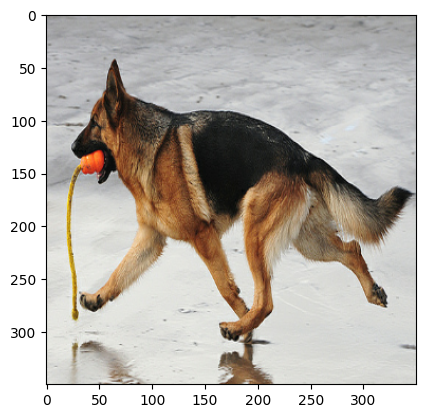

Predicted Caption:  a brown and black dog is standing on the beach


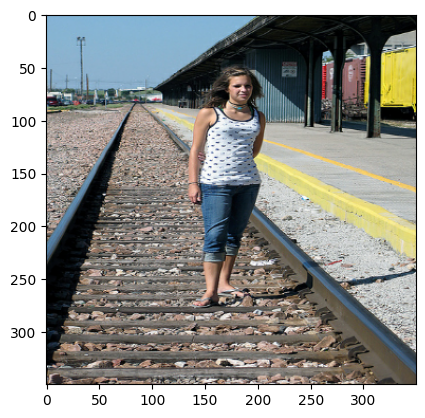

Predicted Caption:  a woman stands on a sidewalk with a city street


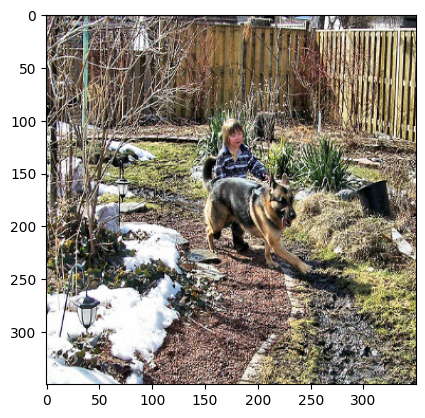

Predicted Caption:  two dogs are playing in a pile of leaves


In [ ]:
#variable that contains unique tokens
vocab = vectorization.get_vocabulary()

#dictionary to map token indices to the corresponding words
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = Sequence_size - 1
valid_images = list(valid_data.keys())

#function to generate random images from validation dataset
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)  #decodes and resizes the image
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Expands the dimensions of the image and pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    #Loop iterates until maximum caption length is reached or sometimes when end token is reached
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    #Printing generated captions by removing the start and end tokens
    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Checking predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

**Generating Captions**

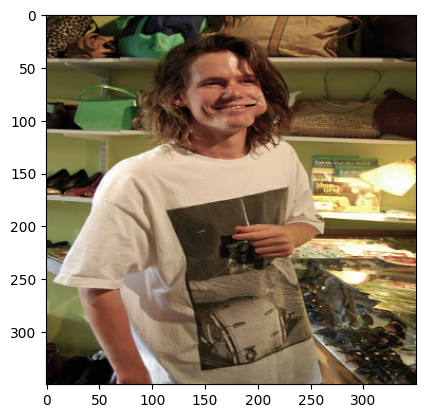

Predicted Caption:  a man in a yellow shirt and a woman in a yellow shirt is standing next to a man in a black shirt


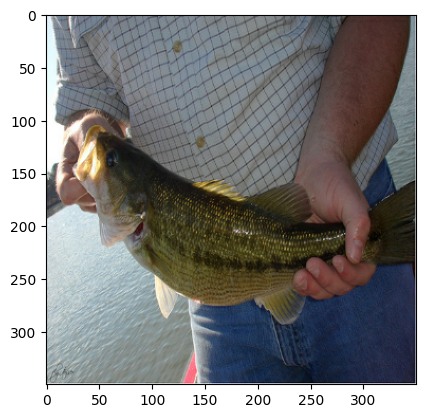

Predicted Caption:  a woman is standing next to a white building


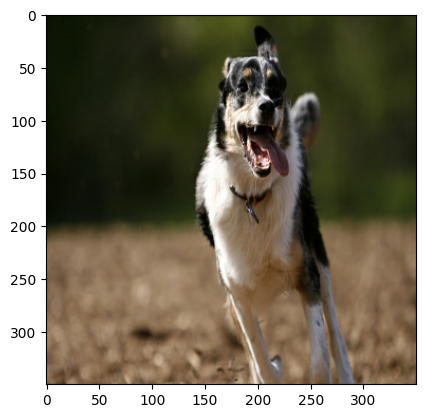

Predicted Caption:  a dog is running through the water


In [ ]:
#Results of generated captions
generate_caption()
generate_caption()
generate_caption()

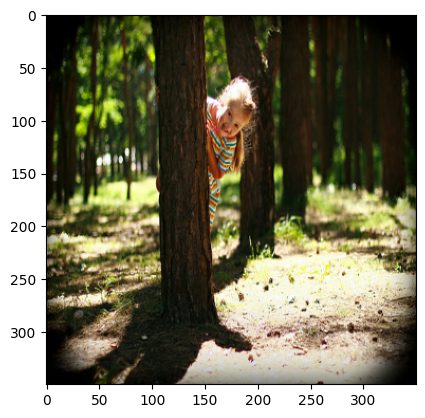

Predicted Caption:  a dog is running through the woods


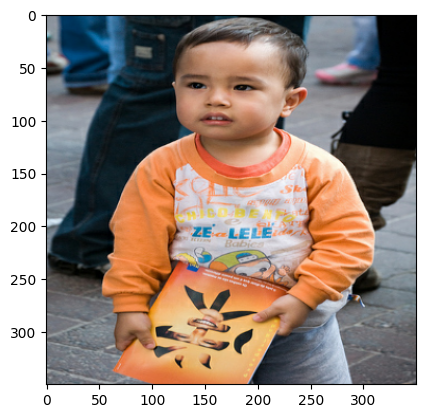

Predicted Caption:  a baby in a yellow shirt is holding a baby with his arms


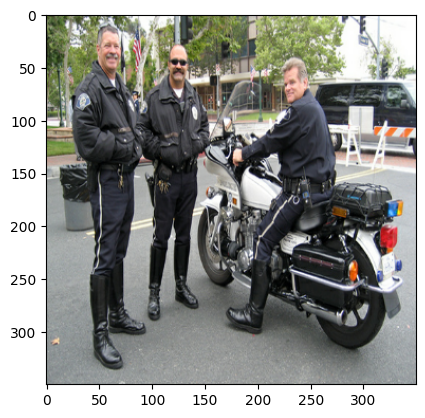

Predicted Caption:  two men in black leather jackets and white motorcycle


In [ ]:
generate_caption()
generate_caption()
generate_caption()

**Plots to compare Accuracy and Loss with Epochs**

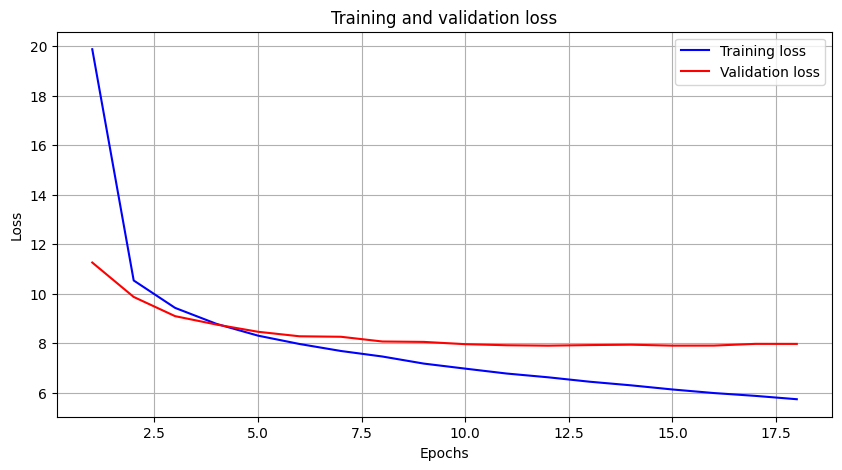

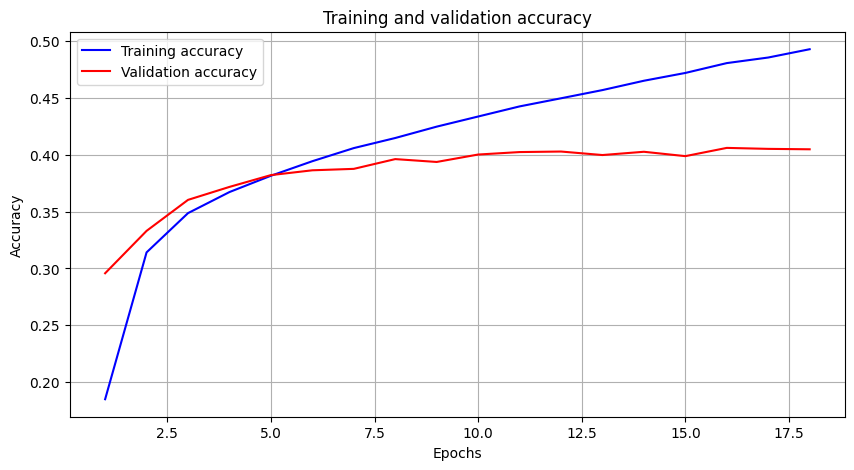

In [ ]:
import matplotlib.pyplot as plt

# Extract data from history
history = caption_model.history.history
epochs = range(1, len(history['loss']) + 1)
loss = history['loss']
val_loss = history['val_loss']
acc = history['acc']
val_acc = history['val_acc']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()